                                                text
0  [ king henry iv ] so shaken as we are, so wan ...
1  [ westmoreland ] my liege, this haste was hot ...
2  [ king henry iv ] it seems then that the tidin...
3  [ westmoreland ] this match'd with other did, ...
4  [ king henry iv ] here is a dear, a true indus...


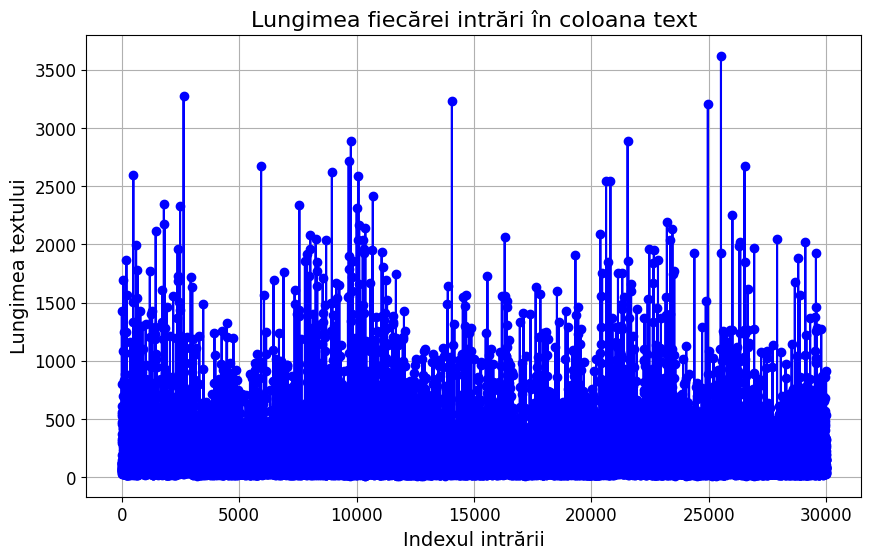

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt

file_path = "/kaggle/input/shaker-lines/merged_shakespeare_lines.csv"
data = pd.read_csv(file_path)

print(data.head())

data['text_length'] = data['text'].apply(len)

# Creăm plot-ul
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['text_length'], marker='o', linestyle='-', color='b')
plt.title('Lungimea fiecărei intrări în coloana text', fontsize=16)
plt.xlabel('Indexul intrării', fontsize=14)
plt.ylabel('Lungimea textului', fontsize=14)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [2]:

from typing import List

class CharacterTokenizer:
    def __init__(self, special_tokens: List[str] = ["<SOS>", "<EOS>", "<UNK>", "<PAD>"]):
        self.special_tokens = special_tokens
        self.vocab = {ch: i for i, ch in enumerate(special_tokens)}
        self.inverse_vocab = {i: ch for ch, i in self.vocab.items()}

    def add_text_to_vocab(self, text: str):
        for char in text:
            if char not in self.vocab:
                idx = len(self.vocab)
                self.vocab[char] = idx
                self.inverse_vocab[idx] = char

    def tokenize(self, text: str) -> List[str]:
        tokens = ["<SOS>"] + list(text) + ["<EOS>"]
        return tokens

    def convert_tokens_to_ids(self, tokens: List[str]) -> List[int]:
        return [self.vocab.get(token, self.vocab["<UNK>"]) for token in tokens]

    def convert_ids_to_tokens(self, ids: List[int]) -> List[str]:
        return [self.inverse_vocab[id] for id in ids]

    def detokenize(self, tokens: List[str]) -> str:
        return "".join([t for t in tokens if t not in self.special_tokens])

In [3]:
tokenizer = CharacterTokenizer()

text = "Anne, has apples."
tokenizer.add_text_to_vocab(text)

tokens = tokenizer.tokenize(text)
print("Tokens:", tokens)

ids = tokenizer.convert_tokens_to_ids(tokens)
print("Token IDs:", ids)

reconstructed_tokens = tokenizer.convert_ids_to_tokens(ids)
print("Reconstructed Tokens:", reconstructed_tokens)

reconstructed_text = tokenizer.detokenize(reconstructed_tokens)
print("Reconstructed Text:", reconstructed_text)

Tokens: ['<SOS>', 'A', 'n', 'n', 'e', ',', ' ', 'h', 'a', 's', ' ', 'a', 'p', 'p', 'l', 'e', 's', '.', '<EOS>']
Token IDs: [0, 4, 5, 5, 6, 7, 8, 9, 10, 11, 8, 10, 12, 12, 13, 6, 11, 14, 1]
Reconstructed Tokens: ['<SOS>', 'A', 'n', 'n', 'e', ',', ' ', 'h', 'a', 's', ' ', 'a', 'p', 'p', 'l', 'e', 's', '.', '<EOS>']
Reconstructed Text: Anne, has apples.


In [4]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import math,copy,re
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
warnings.simplefilter("ignore")
print(torch.__version__)

2.4.0


In [5]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        """
        Args:
            vocab_size: size of vocabulary
            embed_dim: dimension of embeddings
        """
        super(Embedding, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
    def forward(self, x):
        """
        Args:
            x: input vector
        Returns:
            out: embedding vector
        """
        out = self.embed(x)
        return out

In [6]:
class PositionalEmbedding(nn.Module):
    def __init__(self, max_seq_len, embed_model_dim):
        super(PositionalEmbedding, self).__init__()
        self.embed_dim = embed_model_dim
        self.max_seq_len = max_seq_len

        pe = torch.zeros(max_seq_len, self.embed_dim)
        for pos in range(max_seq_len):
            for i in range(0, self.embed_dim, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i) / self.embed_dim)))
                if i + 1 < self.embed_dim:
                    pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1)) / self.embed_dim)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x * math.sqrt(self.embed_dim)
        seq_len = x.size(1)
    
        if seq_len > self.pe.size(1):
            extra_pe = torch.zeros(1, seq_len - self.pe.size(1), self.embed_dim).to(x.device)
            for pos in range(self.pe.size(1), seq_len):
                for i in range(0, self.embed_dim, 2):
                    extra_pe[0, pos - self.pe.size(1), i] = math.sin(pos / (10000 ** ((2 * i) / self.embed_dim)))
                    if i + 1 < self.embed_dim:
                        extra_pe[0, pos - self.pe.size(1), i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1)) / self.embed_dim)))
            self.pe = torch.cat([self.pe, extra_pe], dim=1)
        
        x = x + self.pe[:, :seq_len].to(x.device)
        return x

In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=512, n_heads=8):
        """
        Args:
            embed_dim: dimension of embeding vector output
            n_heads: number of self attention heads
        """
        super(MultiHeadAttention, self).__init__()

        self.embed_dim = embed_dim    #512 dim
        self.n_heads = n_heads   #8
        self.single_head_dim = int(self.embed_dim / self.n_heads)   #512/8 = 64  . each key,query, value will be of 64d

        #key,query and value matrixes    #64 x 64
        # single key matrix for all 8 keys #512x512
        self.W_Q = nn.Parameter(torch.randn(self.embed_dim, self.embed_dim))
        self.W_K = nn.Parameter(torch.randn(self.embed_dim, self.embed_dim))
        self.W_V = nn.Parameter(torch.randn(self.embed_dim, self.embed_dim))
        self.W_O = nn.Parameter(torch.randn(self.embed_dim, self.embed_dim))

    def forward(self,key,query,value):    #batch_size x sequence_length x embedding_dim    # 32 x 10 x 512

        """
        Args:
           key : key vector
           query : query vector
           value : value vector
           mask: mask for decoder

        Returns:
           output vector from multihead attention
        """
        batch_size, seq_length, _ = key.size()

        # query dimension can change in decoder during inference.
        # so we cant take general seq_length
        seq_length_query = query.size(1)

        Q = torch.matmul(query, self.W_Q)
        K = torch.matmul(key, self.W_K)
        V = torch.matmul(value, self.W_V)

        Q = Q.view(batch_size, seq_length_query, self.n_heads, self.single_head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_length, self.n_heads, self.single_head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_length, self.n_heads, self.single_head_dim).transpose(1, 2)

        K_T = K.transpose(-1, -2)
        product = torch.matmul(Q, K_T)  #(32 x 8 x 10 x 64) x (32 x 8 x 64 x 10) = #(32x8x10x10)

        mask = torch.triu(torch.ones(seq_length, seq_length), diagonal=1).bool().to(product.device)
        mask = mask.unsqueeze(0).unsqueeze(0).expand(batch_size, self.n_heads, -1, -1)
        product = product.masked_fill(mask, float('-inf'))

        # product = product / torch.sqrt(self.single_head_dim) # / sqrt(64)
        product = product / torch.sqrt(torch.tensor(self.single_head_dim, dtype=torch.float32))

        scores = F.softmax(product, dim=-1)
        scores = torch.matmul(scores, V)  ##(32x8x 10x 10) x (32 x 8 x 10 x 64) = (32 x 8 x 10 x 64)

        output = scores.transpose(1,2).contiguous().view(batch_size, seq_length_query, self.embed_dim)  # (32x8x10x64) -> (32x10x8x64)  -> (32,10,512)
        output = torch.matmul(output, self.W_O)
        return output

In [8]:
class LayerNorm(nn.Module):
    def __init__(self, embed_dim, eps=1e-6):
        """
        Args:
            embed_dim: Dimension of the embedding
            eps: Small value to avoid division by zero
        """
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(embed_dim))  # Scale parameter
        self.beta = nn.Parameter(torch.zeros(embed_dim))  # Shift parameter
        self.eps = eps

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch_size, seq_len, embed_dim)

        Returns:
            Normalized tensor
        """
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        x_norm = (x - mean) / (std + self.eps)
        return self.gamma * x_norm + self.beta

In [9]:
class FeedForward(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        """
        Args:
            embed_dim: Dimension of the embedding
            hidden_dim: Dimension of the hidden layer (usually 4x embed_dim)
        """
        super(FeedForward, self).__init__()
        self.linear1 = nn.Parameter(torch.randn(embed_dim, hidden_dim))
        self.linear2 = nn.Parameter(torch.randn(hidden_dim, embed_dim))
        self.bias1 = nn.Parameter(torch.zeros(hidden_dim))
        self.bias2 = nn.Parameter(torch.zeros(embed_dim))

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch_size, seq_len, embed_dim)

        Returns:
            Output tensor of shape (batch_size, seq_len, embed_dim)
        """
        # Linear 1 + activation
        hidden = F.relu(torch.matmul(x, self.linear1) + self.bias1)
        # Linear 2
        output = torch.matmul(hidden, self.linear2) + self.bias2
        return output

In [10]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, n_heads, hidden_dim):
        """
        Args:
            embed_dim: Dimension of the embedding
            n_heads: Number of attention heads
            hidden_dim: Hidden size for the feedforward network
        """
        super(TransformerBlock, self).__init__()
        self.layer_norm1 = LayerNorm(embed_dim)
        self.layer_norm2 = LayerNorm(embed_dim)
        self.attention = MultiHeadAttention(embed_dim, n_heads)
        self.feed_forward = FeedForward(embed_dim, hidden_dim)

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch_size, seq_len, embed_dim)

        Returns:
            Output tensor of shape (batch_size, seq_len, embed_dim)
        """
        # LayerNorm -> Attention -> Residual connection
        attn_input = self.layer_norm1(x)
        attn_output = self.attention(attn_input, attn_input, attn_input)
        x = x + attn_output

        # LayerNorm -> Feedforward -> Residual connection
        ff_input = self.layer_norm2(x)
        ff_output = self.feed_forward(ff_input)
        x = x + ff_output

        return x

In [11]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, max_seq_len, embed_dim=512, n_heads=8, n_layers=6, hidden_dim=2048):
        """
        Args:
            vocab_size: Size of the vocabulary
            max_seq_len: Maximum sequence length
            embed_dim: Dimension of the embedding
            n_heads: Number of attention heads
            n_layers: Number of transformer layers
            hidden_dim: Hidden size for the feedforward network
        """
        super(TransformerDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_embedding = PositionalEmbedding(max_seq_len, embed_dim)
        self.layers = nn.ModuleList(
            [TransformerBlock(embed_dim, n_heads, hidden_dim) for _ in range(n_layers)]
        )
        self.output_projection = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch_size, seq_len)

        Returns:
            Output logits of shape (batch_size, seq_len, vocab_size)
        """
        # Embed tokens and add positional encoding
        x = self.embedding(x)  # (batch_size, seq_len, embed_dim)
        x = self.positional_embedding(x)  # (batch_size, seq_len, embed_dim)

        # Pass through transformer layers
        for layer in self.layers:
            x = layer(x)

        # Project to vocabulary size
        logits = self.output_projection(x)  # (batch_size, seq_len, vocab_size)
        return logits

In [12]:
from sklearn.model_selection import train_test_split

tokenizer = CharacterTokenizer()
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)

print(len(train_data), len(test_data))

for line in train_data['text']:
    tokenizer.add_text_to_vocab(line)

train_data['tokens'] = train_data['text'].apply(lambda x: tokenizer.tokenize(x))
train_data['token_ids'] = train_data['tokens'].apply(lambda x: tokenizer.convert_tokens_to_ids(x))

test_data['tokens'] = test_data['text'].apply(lambda x: tokenizer.tokenize(x))
test_data['token_ids'] = test_data['tokens'].apply(lambda x: tokenizer.convert_tokens_to_ids(x))

def prepare_inputs_outputs(token_ids):
    input_ids = token_ids[:-1]  # Toate token-urile mai puțin ultimul (<EOS>)
    output_ids = token_ids[1:]  # Toate token-urile mai puțin primul (<SOS>)
    return input_ids, output_ids

train_data['input_output'] = train_data['token_ids'].apply(prepare_inputs_outputs)
train_data['input_ids'] = train_data['input_output'].apply(lambda x: x[0])  # Extrage doar input_ids
train_data['output_ids'] = train_data['input_output'].apply(lambda x: x[1])  # Extrage doar output_ids

test_data['input_output'] = test_data['token_ids'].apply(prepare_inputs_outputs)
test_data['input_ids'] = test_data['input_output'].apply(lambda x: x[0])  # Extrage doar input_ids
test_data['output_ids'] = test_data['input_output'].apply(lambda x: x[1])  # Extrage doar output_ids

train_data.drop(columns=['input_output'], inplace=True)
test_data.drop(columns=['input_output'], inplace=True)

print(train_data[['text', 'tokens', 'input_ids', 'output_ids']].head())
print("Dimensiunea vocabularului:", len(tokenizer.vocab))
print("Primele 54 intrări din vocabular:", list(tokenizer.vocab.items())[:54])

26997 3000
                                                    text  \
346            [ bardolph ] what think you they portend?   
13028  [ gloucester ] come, come, away. exeunt all bu...   
8821   [ lord polonius ] you know, sometimes he walks...   
25676  [ timon ] if thou hatest curses, stay not, fly...   
7534   [ coriolanus ] wife, mother, child, i know not...   

                                                  tokens  \
346    [<SOS>, [,  , b, a, r, d, o, l, p, h,  , ],  ,...   
13028  [<SOS>, [,  , g, l, o, u, c, e, s, t, e, r,  ,...   
8821   [<SOS>, [,  , l, o, r, d,  , p, o, l, o, n, i,...   
25676  [<SOS>, [,  , t, i, m, o, n,  , ],  , i, f,  ,...   
7534   [<SOS>, [,  , c, o, r, i, o, l, a, n, u, s,  ,...   

                                               input_ids  \
346    [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 5, 14, 5...   
13028  [0, 4, 5, 24, 11, 10, 21, 25, 22, 26, 16, 22, ...   
8821   [0, 4, 5, 11, 10, 8, 9, 5, 12, 10, 11, 10, 18,...   
25676  [0, 4, 5, 16, 17, 27

In [13]:
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import torch
import numpy as np

def pad_sequences(sequences, max_len, pad_token="<PAD>"):
    padded_sequences = []
    pad_id = tokenizer.vocab.get(pad_token, None)

    if pad_id is None:
        raise ValueError("Padding token not found!")

    for seq in sequences:
        seq = seq.tolist() if isinstance(seq, torch.Tensor) else seq

        if len(seq) < max_len:
            padded_seq = seq + [pad_id] * (max_len - len(seq))
        else:
            padded_seq = seq[:max_len]

        padded_sequences.append(torch.tensor(padded_seq, dtype=torch.long))

    return padded_sequences

# Custom Dataset
class ShakespeareDataset(Dataset):
    def __init__(self, data, max_seq_len):
        self.data = data
        self.max_seq_len = max_seq_len  # Lungimea maximă a secvenței
        self.pad_token = "<PAD>"  # Tokenul de padding

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returnează perechile input_ids și output_ids ca tensori PyTorch.
        """
        input_ids = self.data.iloc[idx]['input_ids']
        output_ids = self.data.iloc[idx]['output_ids']

        # print(type(input_ids), type(output_ids))
        # print(input_ids.size(), output_ids.size(), "A")

        # input_ids = pad_sequences([input_ids], self.max_seq_len, self.pad_token)[0]
        # output_ids = pad_sequences([output_ids], self.max_seq_len, self.pad_token)[0]

        # print(input_ids.size(), output_ids.size())
        return torch.tensor(input_ids, dtype=torch.long), torch.tensor(output_ids, dtype=torch.long)

def collate_fn(batch):
    # max_len = max(len(item[0]) for item in batch)
    max_len = 512
    # print(len(batch))
    # for item in batch:
    #   print(item[0], item[1], "-", len(item[0]), max_len)
    #   print()

    input_batch = [pad_sequences([item[0]], max_len)[0] for item in batch]
    output_batch = [pad_sequences([item[1]], max_len)[0] for item in batch]

    # Asigurăm că datele sunt de tip integer valid
    # input_batch = [list(map(int, seq)) for seq in input_batch]  # Convertim elementele la tip integer
    # output_batch = [list(map(int, seq)) for seq in output_batch]
    # print(input_batch)

    # input_tensor = torch.tensor(input_batch, dtype=torch.long)
    # output_tensor = torch.tensor(output_batch, dtype=torch.long)

    input_tensor = torch.stack([torch.tensor(seq, dtype=torch.long) for seq in input_batch])
    output_tensor = torch.stack([torch.tensor(seq, dtype=torch.long) for seq in output_batch])

    # print(input_tensor)
    # input_tensor = torch.tensor(input_batch, dtype=torch.long)
    # output_tensor = torch.tensor(output_batch, dtype=torch.long)

    return input_tensor, output_tensor


# Create DataLoaders
batch_size = 128
max_seq_len = 512
train_dataset = ShakespeareDataset(train_data, max_seq_len)
test_dataset = ShakespeareDataset(test_data, max_seq_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Initialize model
vocab_size = len(tokenizer.vocab)  # Dimensiunea vocabularului generat de tokenizer
device = "cuda" if torch.cuda.is_available() else "cpu"  # Asigură rularea pe GPU dacă este disponibil

# Configurația modelului Transformer Decoder
model = TransformerDecoder(
    vocab_size=vocab_size,  # Numărul total de tokeni unici
    max_seq_len=max_seq_len,        # Lungimea maximă a secvenței
    embed_dim=384,          # Dimensiunea vectorului de embedding
    n_heads=6,              # Numărul de capete de atenție
    n_layers=6,             # Numărul de straturi în Transformer
    hidden_dim=128         # Dimensiunea feed-forward intermediară
)
model = model.to(device)

# Loss și optimizer
criterion = nn.CrossEntropyLoss()  # Obiectivul pentru limbaj cauzal
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [14]:
import math

# Training Loop
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for input_ids, output_ids in train_loader:
        input_ids, output_ids = input_ids.to(device), output_ids.to(device)  # Muta tensori pe GPU (dacă este disponibil)
        optimizer.zero_grad()  # Resetează gradientele

        # Forward pass
        logits = model(input_ids)  # Output-ul modelului: (batch_size, seq_len, vocab_size)

        # Compute loss
        loss = criterion(logits.view(-1, vocab_size), output_ids.view(-1))  # Aplatizează tensori pentru CrossEntropyLoss
        loss.backward()  # Backward pass
        optimizer.step()  # Actualizează greutățile

        total_loss += loss.item()  # Adaugă pierderea curentă la pierderea totală

    # Calcularea pierderii medii pe epocă
    avg_loss = total_loss / len(train_loader)
    perplexity = math.exp(avg_loss)  # Calculul perplexity folosind loss-ul mediu
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Perplexity: {perplexity:.4f}")

    text = data.iloc[1]['text']
    tokens = tokenizer.tokenize(text)
    
    # Conversia tokenilor în ID-uri
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    
    # Împachetăm input_ids într-un tensor și îl trimitem prin model
    input_tensor = torch.tensor([input_ids]).to(device)
    
    # Modelul va returna predicțiile pentru secvența de intrare
    model.eval()
    with torch.no_grad():
        logits = model(input_tensor)  # (batch_size, seq_len, vocab_size)
    
    # Predicțiile sunt în logits, iar acum trebuie să extragem token-ul cu probabilitatea maximă
    predicted_ids = torch.argmax(logits, dim=-1).squeeze().cpu().numpy()  # Extragem predicțiile
    # Conversia ID-urilor înapoi în token-uri
    predicted_tokens = tokenizer.convert_ids_to_tokens(predicted_ids)
    
    # Reconstruirea textului din token-uri
    predicted_text = tokenizer.detokenize(predicted_tokens)
    print("Predicted Text:", predicted_text)

# Evaluare pe setul de test
model.eval()
test_loss = 0
with torch.no_grad():
    for input_ids, output_ids in test_loader:
        input_ids, output_ids = input_ids.to(device), output_ids.to(device)

        logits = model(input_ids)
        loss = criterion(logits.view(-1, vocab_size), output_ids.view(-1))
        test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    print(f"Test Loss: {avg_test_loss:.4f}")


Epoch 1/20, Loss: 411.0633, Perplexity: 33307524813209470662127451956098681397920197521698127275689087547591522943491486003284306301471710046284987290596298975822432751494661085801209469881189983911058876165305803997184.0000
Predicted Text: h     n o  g  l  o ott5ost ,5fstes o mfxt ooc i cxi ?emietettobuaboerltmu rctra,oufiegeotpashe[(aff(vcmttfmatfm agaev vgkmev?m?ordahkorehft  dh rt  hfsooho.t,h.ephe  .he kpahe pbha[faa[ h md heekaae k hd u anhae he heah  k aek?eae haehaan dhhnhaicaha  haee nrdhehri hf7d hnd   el eahlhe eb rf  ka   frl e e oosahl defzs asu asheeals eae7ereedlnsnl l?l,ahreefhl elh ln, le?el  l?l fn fl    cld elohel ]hdc c  eldlpphhk :mae6  hae:ehchhx dlhfld]xa elfh  flh che chf hhelhfahx hheyxhox elhkvh d h k?oa uvfh sen
Epoch 2/20, Loss: 186.7032, Perplexity: 1213831380704352232210536125141375621344492345016677013269451478376024734831738880.0000
Predicted Text: [ ah     os  a c o     w ecoieoo atfoeie  i ota kaoenm id 5i d  blfecoot ato  teee  hteto thkteaot  do  k  

In [15]:
import os

output_dir = '/kaggle/working/output'
os.makedirs(output_dir, exist_ok=True)

model_save_path = os.path.join(output_dir, 'transformer_decoder_model2.pt')
torch.save(model.state_dict(), model_save_path)

print(f"Modelul a fost salvat în {model_save_path}")

Modelul a fost salvat în /kaggle/working/output/transformer_decoder_model2.pt


In [16]:
text = data.iloc[1]['text']
tokens = tokenizer.tokenize(text)
print("Tokens:", tokens)

# Conversia tokenilor în ID-uri
input_ids = tokenizer.convert_tokens_to_ids(tokens)
print("Input IDs:", input_ids)

# Împachetăm input_ids într-un tensor și îl trimitem prin model
input_tensor = torch.tensor([input_ids]).to(device)

# Modelul va returna predicțiile pentru secvența de intrare
model.eval()
with torch.no_grad():
    logits = model(input_tensor)  # (batch_size, seq_len, vocab_size)

# Predicțiile sunt în logits, iar acum trebuie să extragem token-ul cu probabilitatea maximă
print(logits.size())
predicted_ids = torch.argmax(logits, dim=-1).squeeze().cpu().numpy()  # Extragem predicțiile
# Conversia ID-urilor înapoi în token-uri
predicted_tokens = tokenizer.convert_ids_to_tokens(predicted_ids)
print("Predicted Tokens:", predicted_tokens)

# Reconstruirea textului din token-uri
predicted_text = tokenizer.detokenize(predicted_tokens)
print("Predicted Text:", predicted_text)


Tokens: ['<SOS>', '[', ' ', 'w', 'e', 's', 't', 'm', 'o', 'r', 'e', 'l', 'a', 'n', 'd', ' ', ']', ' ', 'm', 'y', ' ', 'l', 'i', 'e', 'g', 'e', ',', ' ', 't', 'h', 'i', 's', ' ', 'h', 'a', 's', 't', 'e', ' ', 'w', 'a', 's', ' ', 'h', 'o', 't', ' ', 'i', 'n', ' ', 'q', 'u', 'e', 's', 't', 'i', 'o', 'n', ',', ' ', 'a', 'n', 'd', ' ', 'm', 'a', 'n', 'y', ' ', 'l', 'i', 'm', 'i', 't', 's', ' ', 'o', 'f', ' ', 't', 'h', 'e', ' ', 'c', 'h', 'a', 'r', 'g', 'e', ' ', 's', 'e', 't', ' ', 'd', 'o', 'w', 'n', ' ', 'b', 'u', 't', ' ', 'y', 'e', 's', 't', 'e', 'r', 'n', 'i', 'g', 'h', 't', ':', ' ', 'w', 'h', 'e', 'n', ' ', 'a', 'l', 'l', ' ', 'a', 't', 'h', 'w', 'a', 'r', 't', ' ', 't', 'h', 'e', 'r', 'e', ' ', 'c', 'a', 'm', 'e', ' ', 'a', ' ', 'p', 'o', 's', 't', ' ', 'f', 'r', 'o', 'm', ' ', 'w', 'a', 'l', 'e', 's', ' ', 'l', 'o', 'a', 'd', 'e', 'n', ' ', 'w', 'i', 't', 'h', ' ', 'h', 'e', 'a', 'v', 'y', ' ', 'n', 'e', 'w', 's', ',', ' ', 'w', 'h', 'o', 's', 'e', ' ', 'w', 'o', 'r', 's', 't', ' 

In [17]:
import math

# Training Loop
epochs = 20
for epoch in range(10, epochs):
    model.train()
    total_loss = 0

    for input_ids, output_ids in train_loader:
        input_ids, output_ids = input_ids.to(device), output_ids.to(device)  # Muta tensori pe GPU (dacă este disponibil)
        optimizer.zero_grad()  # Resetează gradientele

        # Forward pass
        logits = model(input_ids)  # Output-ul modelului: (batch_size, seq_len, vocab_size)

        # Compute loss
        loss = criterion(logits.view(-1, vocab_size), output_ids.view(-1))  # Aplatizează tensori pentru CrossEntropyLoss
        loss.backward()  # Backward pass
        optimizer.step()  # Actualizează greutățile

        total_loss += loss.item()  # Adaugă pierderea curentă la pierderea totală

    text = data.iloc[1]['text']
    tokens = tokenizer.tokenize(text)
    
    # Conversia tokenilor în ID-uri
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    
    # Împachetăm input_ids într-un tensor și îl trimitem prin model
    input_tensor = torch.tensor([input_ids]).to(device)
    
    # Modelul va returna predicțiile pentru secvența de intrare
    model.eval()
    with torch.no_grad():
        logits = model(input_tensor)  # (batch_size, seq_len, vocab_size)
    
    # Predicțiile sunt în logits, iar acum trebuie să extragem token-ul cu probabilitatea maximă
    predicted_ids = torch.argmax(logits, dim=-1).squeeze().cpu().numpy()  # Extragem predicțiile
    # Conversia ID-urilor înapoi în token-uri
    predicted_tokens = tokenizer.convert_ids_to_tokens(predicted_ids)
    
    # Reconstruirea textului din token-uri
    predicted_text = tokenizer.detokenize(predicted_tokens)
    print("Predicted Text:", predicted_text)

    # Calcularea pierderii medii pe epocă
    avg_loss = total_loss / len(train_loader)
    perplexity = math.exp(avg_loss)  # Calculul perplexity folosind loss-ul mediu
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Perplexity: {perplexity:.4f}")

# Evaluare pe setul de test
model.eval()
test_loss = 0
with torch.no_grad():
    for input_ids, output_ids in test_loader:
        input_ids, output_ids = input_ids.to(device), output_ids.to(device)

        logits = model(input_ids)
        loss = criterion(logits.view(-1, vocab_size), output_ids.view(-1))
        test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    print(f"Test Loss: {avg_test_loss:.4f}")

Predicted Text: [ lll   lu ly    s  il  e  ihantt tt   i t  nh l mes  htn  ind.m nd ilt t  mnom e mien   i   i li iys i      dt,e  iie dixiiixheix  i e e ihx  ixill  iqel iini  iiln  giilheie ne ig i  iiin ,iin   iin  i in i i,iglyl,i l  l ,  il,n lgli i,i ,gi  ia, ,     il ,i  i lli ixlxlg  i i,il  ,lsln ing iill iel,g  i,  iin iy i i,i s ,iitg  i  i in ii,l i ngi ne,g ini!i s ng i  iil,ir, rl,mys!he,e,  msr gmie ,,m ,n mh er,,m e,e,min,m,lhem l,l,, m,loemy,n,,i m,in rir,,m,eng,  e n,l g me m,ef,rmiri,iif rgm fgrmn,m n mgf,myrmit,ifl,m lhim,in rmer,fi mfem,rf rgif   
Epoch 11/20, Loss: 2.2810, Perplexity: 9.7868
Predicted Text: [ snn  end  no   io aln    yhes wen h ye  yenhyndyes  hnne ynd y ndoasn nh tn yhe yeene  y   y nhdyer yo     dn e  yoe dyn  ynheonehyhe e y!n  ynypn  y en ynn   y nn  dy n eye neoyd eo yae a ya eo yano y en y e yt el y  e s  e yl n st yhe y  ty  ye e   e tese yh y s ehyn nskthyhe ynee  slneynk yisl yel k  i e yintyeoyhe yes  yenk ty  yhenhyi lte nkyhn  k ynyhe 

In [18]:
import math

# Training Loop
epochs = 30
for epoch in range(20, epochs):
    model.train()
    total_loss = 0

    for input_ids, output_ids in train_loader:
        input_ids, output_ids = input_ids.to(device), output_ids.to(device)  # Muta tensori pe GPU (dacă este disponibil)
        optimizer.zero_grad()  # Resetează gradientele

        # Forward pass
        logits = model(input_ids)  # Output-ul modelului: (batch_size, seq_len, vocab_size)

        # Compute loss
        loss = criterion(logits.view(-1, vocab_size), output_ids.view(-1))  # Aplatizează tensori pentru CrossEntropyLoss
        loss.backward()  # Backward pass
        optimizer.step()  # Actualizează greutățile

        total_loss += loss.item()  # Adaugă pierderea curentă la pierderea totală

    text = data.iloc[1]['text']
    tokens = tokenizer.tokenize(text)
    
    # Conversia tokenilor în ID-uri
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    
    # Împachetăm input_ids într-un tensor și îl trimitem prin model
    input_tensor = torch.tensor([input_ids]).to(device)
    
    # Modelul va returna predicțiile pentru secvența de intrare
    model.eval()
    with torch.no_grad():
        logits = model(input_tensor)  # (batch_size, seq_len, vocab_size)
    
    # Predicțiile sunt în logits, iar acum trebuie să extragem token-ul cu probabilitatea maximă
    predicted_ids = torch.argmax(logits, dim=-1).squeeze().cpu().numpy()  # Extragem predicțiile
    # Conversia ID-urilor înapoi în token-uri
    predicted_tokens = tokenizer.convert_ids_to_tokens(predicted_ids)
    
    # Reconstruirea textului din token-uri
    predicted_text = tokenizer.detokenize(predicted_tokens)
    print("Predicted Text:", predicted_text)

    # Calcularea pierderii medii pe epocă
    avg_loss = total_loss / len(train_loader)
    perplexity = math.exp(avg_loss)  # Calculul perplexity folosind loss-ul mediu
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Perplexity: {perplexity:.4f}")

# Evaluare pe setul de test
model.eval()
test_loss = 0
with torch.no_grad():
    for input_ids, output_ids in test_loader:
        input_ids, output_ids = input_ids.to(device), output_ids.to(device)

        logits = model(input_ids)
        loss = criterion(logits.view(-1, vocab_size), output_ids.view(-1))
        test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    print(f"Test Loss: {avg_test_loss:.4f}")

Predicted Text: [ o         r  ]    w s o  a es her   oer weu os wo   hou  or  a rdoo e th oroohe oeer o o   o  odoer wo     dn e  ooe doreeor e r  o e   oer  ororr  ooeu aanl  alun  dp n epe neowd    wieu  wiu   bin  b en b e bduea b u       ba r  d b e b  dbuobe  rou   ee  b uboe e br red  b erbe     ar ard aiea o a d ui   oir ae a e ae   aerd  auoa er oi a e ndo r  d oro eu  rd ouooee orrurl o   ee e   o rudoeeu  o  r oeuer  o e e oer o  eeo s     o  eeoe r  o o er ?o?  o erd oue r sud oe o eu  oo e eou  do ud or o r odu oe oen eur o reeo er  o   ue ou o  u  dau   
Epoch 21/30, Loss: 1.3482, Perplexity: 3.8506
Predicted Text: [ iexe e e eece] ie iie e  ieee iee e i e ieeei' wes  ecue ile iele iecece i oiee ioene  i   i eaeies i     eesee  i e dineein eene o o e oone ini e  ioee i nes ieen sdi s oiosne ie a  ieeu sieu   ien  i en i e ieuei ieus sese iisn seei esieseiu ieses ue  es si ui see inensd  i esiseesesineind iesi ieisd uese ien ie i esies siend  id i en iesi eendi nesd inieed